In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the data
df = pd.read_csv('Electricity Consumption.csv')

In [3]:
df.head()

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107


In [5]:
# Convert 'Date' column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

In [6]:
df.head()

,DATE,Electricty_Consumption_in_TW
0,1973-01-01,35.9728
1,1973-02-01,36.1334
2,1973-03-01,35.0625
3,1973-04-01,33.8416
4,1973-05-01,33.5107


In [8]:
# Set 'Date' as index
df.set_index('DATE', inplace=True)

In [9]:
df.columns

Index(['Electricty_Consumption_in_TW'], dtype='object')

In [10]:
# Sort by date
df = df.sort_index()

In [11]:
# Ensure monthly frequency
df = df.asfreq('MS')  # Month Start

In [12]:
# Rename column for simplicity
df.rename(columns={'Electricty_Consumption_in_TW': 'Consumption'}, inplace=True)

In [13]:
df.head()

,Consumption
DATE,
1973-01-01,35.9728
1973-02-01,36.1334
1973-03-01,35.0625
1973-04-01,33.8416
1973-05-01,33.5107


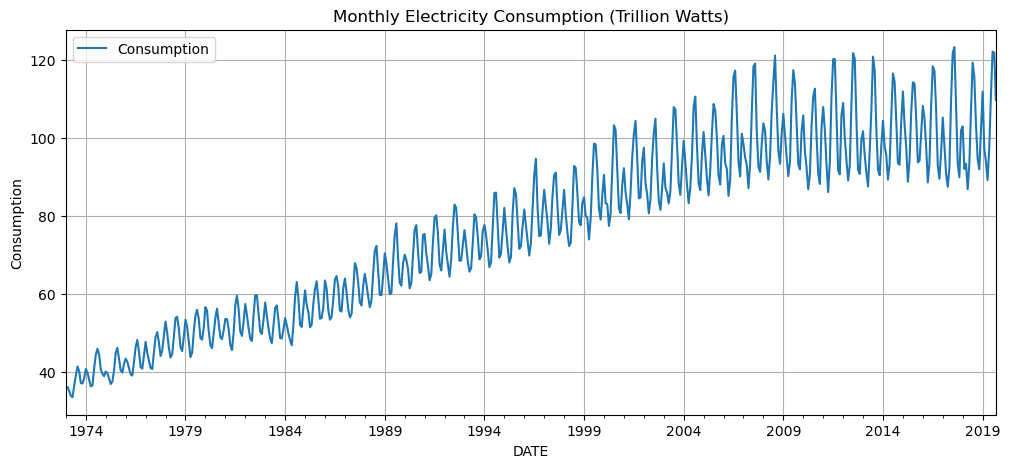

In [15]:
# Plot the data
df.plot(figsize=(12, 5), title='Monthly Electricity Consumption (Trillion Watts)', ylabel='Consumption')
plt.grid(True)
plt.show()

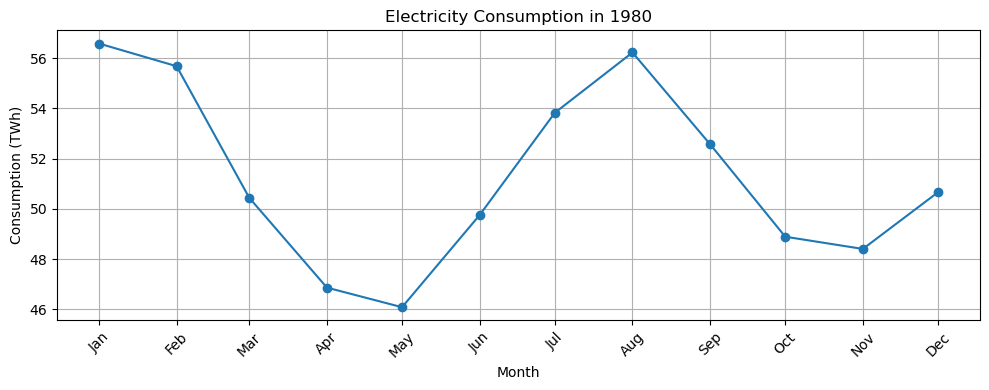

In [17]:
# Filter rows where the year is 1980.
df_1980 = df.loc['1980']

# Plot the 1980 data
plt.figure(figsize=(10, 4))
plt.plot(df_1980.index, df_1980['Consumption'], marker='o', linestyle='-')
plt.title('Electricity Consumption in 1980')
plt.ylabel('Consumption (TWh)')
plt.xlabel('Month')
plt.grid(True)
plt.xticks(df_1980.index, df_1980.index.strftime('%b'), rotation=45)  # Show month names
plt.tight_layout()
plt.show()


In [19]:
# Split data: training = till end of 2018, test = 2019
train = df[:'2018-12']
test = df['2019-01':]

In [20]:
print("Train set shape:", train.shape)
print("Test set shape:", test.shape)

Train set shape: (552, 1)
Test set shape: (9, 1)


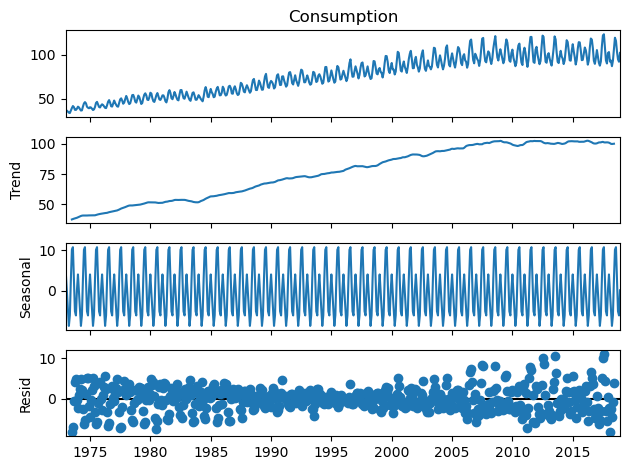

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the training data (monthly = 12 periods per year)
decomposition = seasonal_decompose(train['Consumption'], model='additive', period=12)

# Plot the decomposition
decomposition.plot()
plt.tight_layout()
plt.show()

In [23]:
print(len(test))  # Should print how many months you have in test
print(test.index) # To confirm the months

9
DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01'],
              dtype='datetime64[ns]', name='DATE', freq='MS')


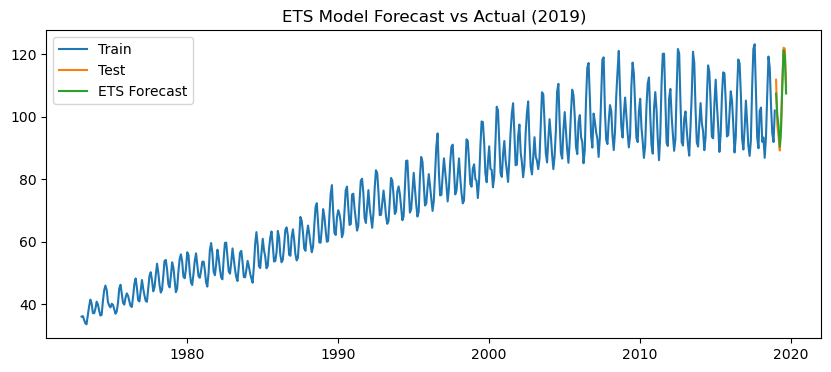

In [25]:
# Match forecast steps with test length
n_test_months = len(test)
ets_forecast = ets_fitted.forecast(steps=n_test_months)

# Plot again
plt.figure(figsize=(10, 4))
plt.plot(train.index, train['Consumption'], label='Train')
plt.plot(test.index, test['Consumption'], label='Test')
plt.plot(test.index, ets_forecast, label='ETS Forecast')
plt.legend()
plt.title('ETS Model Forecast vs Actual (2019)')
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Convert to numpy arrays for computation
y_true = test['Consumption'].values
y_pred = ets_forecast.values

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# RMSPE
rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100

# MAPE
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"ETS Model Error Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"RMSPE: {rmspe:.2f}%")
print(f"MAPE: {mape:.2f}%")

ETS Model Error Metrics:
RMSE: 2.50
RMSPE: 2.41%
MAPE: 2.12%


<Figure size 1000x500 with 0 Axes>

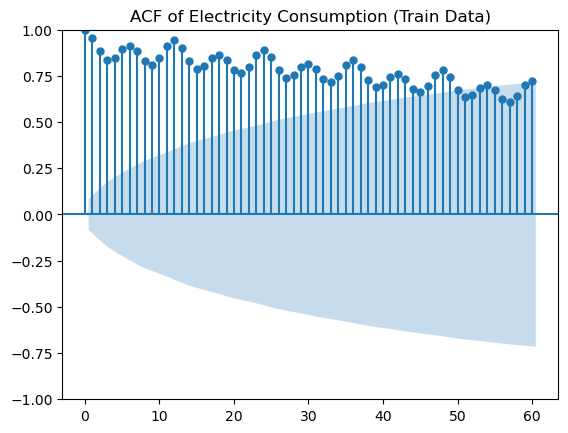

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plot_acf(train['Consumption'], lags=60)
plt.title("ACF of Electricity Consumption (Train Data)")
plt.show()

In [28]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [30]:
# SARIMA(1, 1, 1)(1, 1, 1, 12) as a first trial
sarima_model = SARIMAX(train['Consumption'], 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_results = sarima_model.fit()
print(sarima_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        Consumption   No. Observations:                  552
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1059.194
Date:                            Thu, 17 Apr 2025   AIC                           2128.389
Time:                                    00:01:35   BIC                           2149.706
Sample:                                01-01-1973   HQIC                          2136.736
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6151      0.039     15.746      0.000       0.539       0.692
ma.L1         -0.9414      0.018   

In [31]:
sarima_forecast = sarima_results.predict(start=test.index[0], end=test.index[-1])

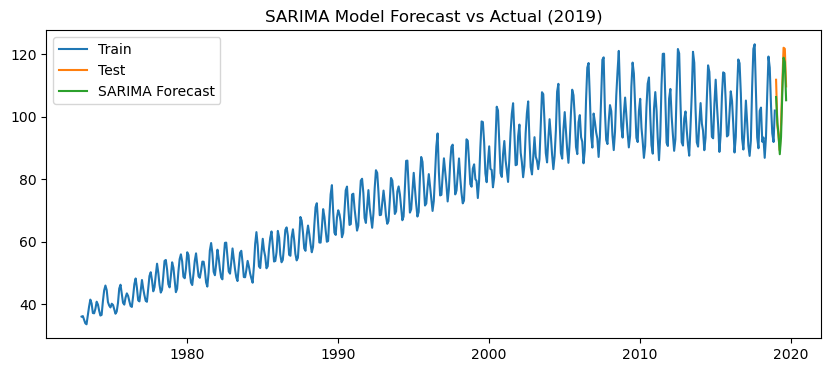

In [32]:
plt.figure(figsize=(10, 4))
plt.plot(train.index, train['Consumption'], label='Train')
plt.plot(test.index, test['Consumption'], label='Test')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.title('SARIMA Model Forecast vs Actual (2019)')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(test['Consumption'], sarima_forecast))
rmspe = np.sqrt(np.mean(np.square(((test['Consumption'] - sarima_forecast) / test['Consumption'])))) * 100
mape = mean_absolute_percentage_error(test['Consumption'], sarima_forecast) * 100

print(f"SARIMA Model Error Metrics:\nRMSE: {rmse:.2f}\nRMSPE: {rmspe:.2f}%\nMAPE: {mape:.2f}%")


SARIMA Model Error Metrics:
RMSE: 3.46
RMSPE: 3.13%
MAPE: 2.75%
